# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs
        
if not os.path.exists('tables'):
    !mkdir tables

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig, write_table

## Classification

Classification might be the most well-known application of Bayesian methods, made famous as the basis of the first generation of [spam filters](https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering) in the 1990s.

In this notebook, I'll demonstrate Bayesian classification using data collected and made available by Dr. Kristen Gorman at the Palmer Long-Term Ecological Research Station in Antarctica.
We'll use this data to classify penguins by species.

This dataset was published to support this article: Gorman, Williams, and Fraser, ["Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus *Pygoscelis*)"](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0090081), March 2014.

The following cell downloads the raw data.

In [4]:
# Load the data files from https://github.com/allisonhorst/palmerpenguins
# With gratitude to Allison Horst (@allison_horst)

import os

if not os.path.exists('penguins_raw.csv'):
    !wget https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/data-raw/penguins_raw.csv

The dataset contains one row for each penguin and one column for each variable, including the measurements we will use for classification.

In [5]:
df = pd.read_csv('penguins_raw.csv')
df.shape

(344, 17)

In [6]:
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


Three species of penguins are represented in the dataset: Adelie, Chinstrap and Gentoo, as shown in this illustration (by Allison Horst, available under the [CC-BY](https://creativecommons.org/licenses/by/2.0/) license):

<img width="400" src="https://pbs.twimg.com/media/EaAWkZ0U4AA1CQf?format=jpg&name=4096x4096">

The measurement we'll use are:

* Body Mass in grams (g).

* Flipper Length in millimeters (mm).

* Culmen Length in millimeters.  

* Culmen Depth in millimeters.

If you are not familiar with the word "culmen", it refers to the [top margin of the beak](https://en.wikipedia.org/wiki/Bird_measurement#Culmen), as shown in the following illustration (also by Allison Horst):

<img width="400" src="https://pbs.twimg.com/media/EaAXQn8U4AAoKUj?format=jpg&name=4096x4096">

## Distributions of measurements

These measurements will be most useful for classification if there are substantial differences between species and small variation within species.  To see whether that is true, and to what degree, I will plot cumulative distribution functions (CDFs) of each measurement for each species. 

For convenience, I'll create a new column, called `Species2`, that contains a shorter version of the species names.

In [7]:
def shorten(species):
    return species.split()[0]

df['Species2'] = df['Species'].apply(shorten)

The following function takes the `DataFrame` and a column name, and returns a dictionary that maps from each species name to a `Cdf` of the values in the given column. 

In [8]:
def make_cdf_map(df, varname, by='Species2'):
    """Make a CDF for each species.
    
    df: DataFrame
    varname: string column name
    by: string column name
    
    returns: dictionary from species name to Cdf
    """
    cdf_map = {}
    grouped = df.groupby(by)[varname]
    for species, group in grouped:
        cdf_map[species] = Cdf.from_seq(group, name=species)
    return cdf_map

The following function plots a `Cdf` of the values in the given column for each species: 

In [9]:
def plot_cdfs(df, varname, by='Species2'):
    """Make a CDF for each species.
    
    df: DataFrame
    varname: string column name
    by: string column name

    returns: dictionary from species name to Cdf
    """
    cdf_map = make_cdf_map(df, varname, by)
    
    for species, cdf in cdf_map.items():
        cdf.plot()
    
    decorate(xlabel=varname,
             ylabel='CDF')

Here's what the distributions look like for culmen length.

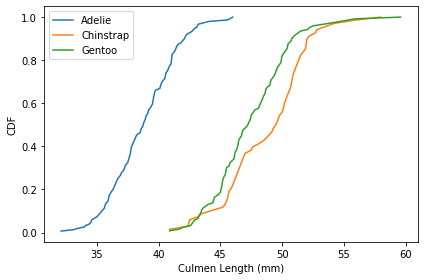

In [10]:
varname = 'Culmen Length (mm)'
plot_cdfs(df, varname)

It looks like we can use culmen length to identify Adelie penguins, but the distributions for the other two species almost entirely overlap.

Here are the distributions for flipper length.

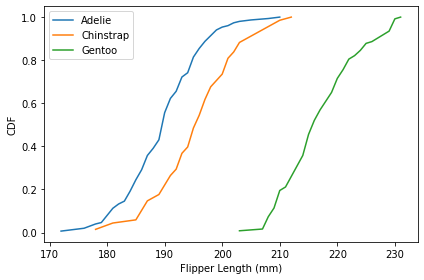

In [11]:
varname = 'Flipper Length (mm)'
plot_cdfs(df, varname)

Using flipper length, we can distinguish Gentoo penguins from the other two species.  So with just these two features, it seems like we should be able to classify penguins with some accuracy.

Here are the distributions for culmen depth.

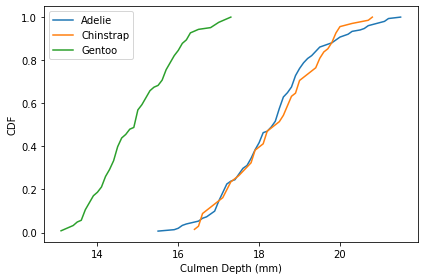

In [12]:
varname = 'Culmen Depth (mm)'
plot_cdfs(df, varname)

And here are the distributions of body mass.

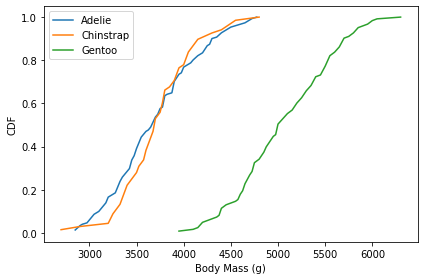

In [13]:
varname = 'Body Mass (g)'
plot_cdfs(df, varname)

Culmen depth and body mass distinguish Gentoo penguins from the other two species, but these features might not add a lot of additional information, beyond flipper length and culmen length.

All of these CDFs show the sigmoid shape characteristic of the normal distribution;  I will take advantage of that observation in the next section.

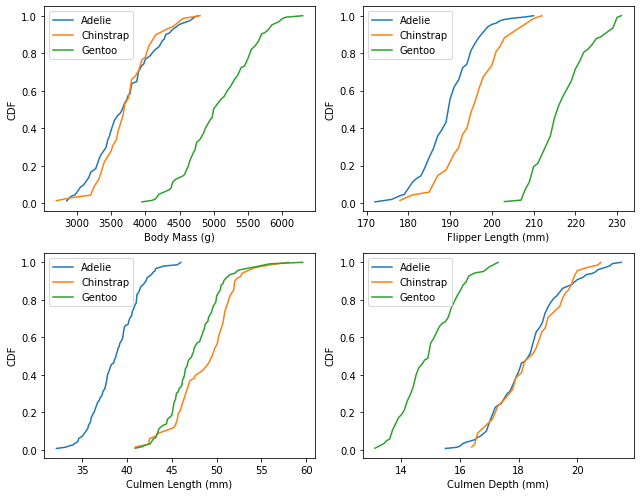

In [14]:
varnames = ['Body Mass (g)', 'Flipper Length (mm)', 'Culmen Length (mm)', 'Culmen Depth (mm)']

plt.figure(figsize=(9,7))
for i, varname in enumerate(varnames):
    plt.subplot(2,2,i+1)
    plot_cdfs(df, varname)
    
savefig('fig10-01')

## Normal models

Now let's use these features to classify penguins.  I'll proceed in the usual Bayesian way:

1. I'll define a prior distribution that represents a hypothesis for each species and a prior probability.

2. I'll compute the likelihood of the data under each hypothesis, and then

3. Compute the posterior probability of each hypothetical species.

To compute the likelihood of the data under each hypothesis, I will use the data to estimate the parameters of a normal distribution for each feature and each species.

The following function takes a `DataFrame` and a column name; it returns a dictionary that maps from each species name to a `norm` object.
`norm` is defined in SciPy; it represents a normal distribution with a given mean and standard deviation.

In [15]:
from scipy.stats import norm

def make_norm_map(df, varname, by='Species2'):
    """Make a map from species to norm object.
    
    df: DataFrame
    varname: string column name
    by: string column name

    returns: dictionary from species name to norm object
    """
    norm_map = {}
    grouped = df.groupby(by)[varname]
    for species, group in grouped:
        mean = group.mean()
        std = group.std()
        norm_map[species] = norm(mean, std)
    return norm_map

For example, here's how we estimate the distributions of flipper length for the three species.

In [16]:
flipper_map = make_norm_map(df, 'Flipper Length (mm)')
flipper_map

{'Adelie': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f6b61c56340>,
 'Chinstrap': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f6b61c56820>,
 'Gentoo': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f6b5b9f4100>}

As usual I will use a `Pmf` to represent the prior distribution.  For simplicity, I'll assume that the three species are equally likely.

In [17]:
hypos = flipper_map.keys()
prior = Pmf(1/3, hypos)
prior

,probs
Adelie,0.333333
Chinstrap,0.333333
Gentoo,0.333333


Now suppose we measure a penguin and find that it's flipper is 210 cm.  What is the probability of that measurement under each hypothesis?

The `norm` object provides `pdf`, which computes the probability density function (PDF) of the normal distribution.  We can use it to compute the likelihood of the observed data in a given distribution.

In [18]:
data = 210
flipper_map['Adelie'].pdf(data)

0.0005557043153857454

The result is a probability density, so we can't interpret it as a probability.  But it is proportional to the likelihood of the data, so we can use it to update the prior.

Here's how we compute the likelihood of the data in each distribution.

In [19]:
likelihood = [flipper_map[hypo].pdf(data) for hypo in hypos]
likelihood

[0.0005557043153857454, 0.007757433347055787, 0.03328865501748979]

Now we can do the update in the usual way.

In [20]:
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
Adelie,0.013358
Chinstrap,0.186469
Gentoo,0.800174


A penguin with a 210 mm flipper has an 80% chance of being a Gentoo and about an 19% chance of being a Chinstrap (assuming that the three species were equally likely before the measurement). 

The following function encapsulates the steps we just ran.
It takes a `Pmf` representing the prior distribution, the observed data, and a map from each hypothesis to the distribution of the feature.

In [21]:
def update_penguin(prior, data, norm_map):
    """Update hypothetical species.
    
    prior: Pmf
    data: measurement of a feature
    norm_map: map from hypothesis to distribution of data
    
    returns: posterior Pmf
    """
    hypos = prior.qs
    likelihood = [norm_map[hypo].pdf(data) for hypo in hypos]
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

The return value is the posterior distribution.

Here's the previous example again, using `update_penguin`:

In [22]:
from utils import write_table

posterior1 = update_penguin(prior, 210, flipper_map)
write_table(posterior1, 'table10-01')
posterior1

,probs
Adelie,0.013358
Chinstrap,0.186469
Gentoo,0.800174


As we saw in the CDFs, flipper length does not distinguish strongly between Adelie and Chinstrap penguins.
If a penguin has a 190 mm flipper, it is almost certainly not a Gentoo, but it is almost equally likely to be Adelie or Chinstrap.

In [23]:
posterior2 = update_penguin(prior, 190, flipper_map)
write_table(posterior2, 'table10-02')
posterior2

,probs
Adelie,0.603445
Chinstrap,0.396463
Gentoo,0.000093


But culmen length *can* make this distinction.  We can estimate distributions of culmen length for each species like this:

In [24]:
culmen_map = make_norm_map(df, 'Culmen Length (mm)')

A penguin with culmen length 38 mm is almost certainly an Adelie.

In [25]:
posterior3 = update_penguin(prior, 38, culmen_map)
write_table(posterior3, 'table10-03')
posterior3

,probs
Adelie,0.988058
Chinstrap,0.004266
Gentoo,0.007675


With culmen length 48 mm, it is probably not an Adelie, but it's about equally likely to be a Chinstrap or Gentoo.

In [26]:
posterior4 = update_penguin(prior, 48, culmen_map)
write_table(posterior4, 'table10-04')
posterior4

,probs
Adelie,0.001557
Chinstrap,0.474658
Gentoo,0.523785


Using one feature at a time, sometimes we can classify penguins with high confidence; sometimes we can't.
We can do better using multiple features.

## Naive Bayesian classification

To make it easier to do multiple updates, I'll use the following function, which takes a prior `Pmf`, sequence of measurements and a corresponding sequence of dictionaries containing estimated distributions.

In [27]:
def update_naive(prior, data_seq, norm_maps):
    """Naive Bayesian classifier
    
    prior: Pmf
    data_seq: sequence of measurements
    norm_maps: sequence of maps from species to distribution
    
    returns: Pmf representing the posterior distribution
    """
    posterior = prior.copy()
    for data, norm_map in zip(data_seq, norm_maps):
        posterior = update_penguin(posterior, data, norm_map)
    return posterior

The return value is a posterior `Pmf`.

I'll use the same features we looked at in the previous section: culmen length and flipper length.

In [28]:
varnames = ['Culmen Length (mm)', 'Flipper Length (mm)']
norm_maps = [culmen_map, flipper_map]

Now suppose we find a penguin with culmen length 48 mm and flipper length 210 mm.
Here's the update:

In [29]:
data_seq = 48, 210
posterior = update_naive(prior, data_seq, norm_maps)
posterior

,probs
Adelie,0.000041
Chinstrap,0.174351
Gentoo,0.825608


It's most likely to be a Gentoo.

In [30]:
posterior.max_prob()

'Gentoo'

I'll loop through the dataset and classify each penguin with these two features.

In [31]:
df['Classification'] = np.nan

for i, row in df.iterrows():
    data_seq = row[varnames]
    posterior = update_naive(prior, data_seq, norm_maps)
    df.loc[i, 'Classification'] = posterior.max_prob()

The result is a new column in the `DataFrame`.  So let's see how many we got right.

In [32]:
len(df)

344

There are 344 penguins in the dataset, but two of them are missing measurements, so we have 342 valid cases.

In [33]:
valid = df['Classification'].notna()
valid.sum()

342

Of those, 324 are classified correctly.

In [34]:
same = df['Species2'] == df['Classification']
same.sum()

324

In [35]:
same.sum() / valid.sum()

0.9473684210526315

Which is almost 95%.

The following function encapsulates these steps.

In [36]:
def accuracy(df):
    """Compute the accuracy of classification.
    
    Compares columns Classification and Species2
    
    df: DataFrame
    """
    valid = df['Classification'].notna()
    same = df['Species2'] == df['Classification']
    return same.sum() / valid.sum()

The classifier we used in this section is called "naive" because it ignores correlations between the features.  To see why that matters, I'll make a less naive classifier: one that takes into account the joint distribution of the features.

## Joint distributions

I'll start by making a scatter plot of the data.

In [37]:
def scatterplot(df, var1, var2):
    """Make a scatter plot.
    
    df: DataFrame
    var1: string column name, x-axis
    var2: string column name, y-axis
    """
    grouped = df.groupby('Species2')
    for species, group in grouped:
        plt.plot(group[var2], group[var1], 'o',
                 alpha=0.4, label=species)
    
    decorate(ylabel=var1, xlabel=var2)

Here's a scatter plot of culmen length and flipper length for the three species.

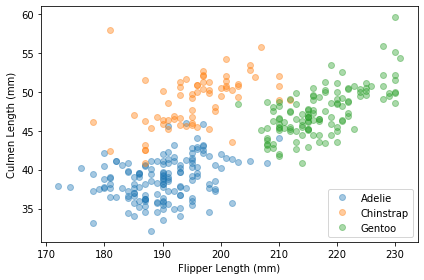

In [38]:
var1 = 'Culmen Length (mm)'
var2 = 'Flipper Length (mm)'

scatterplot(df, var1, var2)

Within each species, there is a clear correlation between culmen length and flipper length.

If we ignore these correlations, we are assuming that the features are independent.  To see what that looks like, I'll make a joint distribution for each species assuming independence.

The following function makes a discrete `Pmf` that approximates a normal distribution.

In [39]:
def make_pmf(dist, sigmas=3, n=101):
    """Make a Pmf approximation to a normal distribution.
    
    dist: norm object
    
    returns: Pmf
    """
    mean, std = dist.mean(), dist.std()
    low = mean - sigmas * std
    high = mean + sigmas * std
    qs = np.linspace(low, high, n)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

We can use it, along with `outer_product` from the previous notebook, to make a joint distribution of culmen length and flipper length for each species.

In [40]:
from utils import outer_product

joint_map = {}
for species in hypos:
    pmf1 = make_pmf(culmen_map[species])
    pmf2 = make_pmf(flipper_map[species])
    joint_map[species] = outer_product(pmf1, pmf2)

And we can use the joint distribution to generate a contour plot.

In [41]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    plt.contour(joint.columns, joint.index, joint, **options)

The following figure compares the data to joint distributions that assume independence.

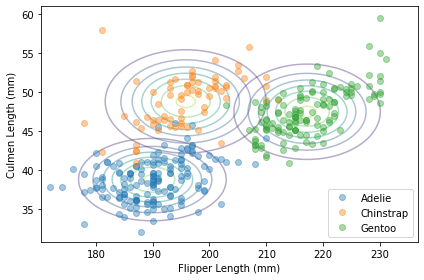

In [42]:
scatterplot(df, var1, var2)

for species in hypos:
    plot_contour(joint_map[species], alpha=0.4)
    
savefig('fig10-02')

The contours of a joint normal distribution form ellipses.  
In this example, because the features are uncorrelated, the ellipses are aligned with the axes.
But they are not well aligned with the data.

We can make a better model of the data, and use it to compute better likelihoods, with a multivariate normal distribution.

## Multivariate normal distribution

As we have seen, a univariate normal distribution is characterized by its mean and standard deviation or variance (where variance is the square of standard deviation).

A multivariate normal distribution is characterized by the means of the features and the **covariance matrix**, which contains the variances, which quantify the spread of the features, and the covariances, which quantify the relationships among them.

We can use the data to estimate the means and covariance matrix for the population of penguins.
First I'll select the columns we want.

In [43]:
features = df[[var1, var2]]
features.head()

,Culmen Length (mm),Flipper Length (mm)
0,39.1,181.0
1,39.5,186.0
2,40.3,195.0
3,NaN,NaN
4,36.7,193.0


And compute the means.

In [44]:
mean = features.mean()
mean

Culmen Length (mm)      43.921930
Flipper Length (mm)    200.915205
dtype: float64

In [45]:
# convert to a DataFrame and write as a table
mean_df = pd.DataFrame(mean, columns=['mean'])
write_table(mean_df, 'table10-04')

The result is a `Series` containing the mean culmen length and flipper length.

We can also compute the covariance matrix:

In [46]:
cov = features.cov()
write_table(cov, 'table10-05')
cov

,Culmen Length (mm),Flipper Length (mm)
Culmen Length (mm),29.807054,50.375765
Flipper Length (mm),50.375765,197.731792


The results is a `DataFrame` with one row and one column for each feature.  The elements on the diagonal are the variances; the elements off the diagonal are covariances.

SciPy provides a `multivariate_normal` object we can use to represent a multivariate normal distribution.
It takes a sequence of means and a covariance matrix as parameters: 

In [47]:
from scipy.stats import multivariate_normal

multinorm = multivariate_normal(mean, cov)
multinorm

The following function makes a `multivariate_normal` object for each species.

In [48]:
def make_multinorm_map(df, varnames):
    """Make a map from each species to a multivariate normal.
    
    df: DataFrame
    varnames: list of string column names
    
    returns: map from species name to multivariate_normal
    """
    multinorm_map = {}
    grouped = df.groupby('Species2')
    for species, group in grouped:
        features = group[varnames]
        mean = features.mean()
        cov = features.cov()
        multinorm_map[species] = multivariate_normal(mean, cov)
    return multinorm_map

And here's how we use it.

In [49]:
multinorm_map = make_multinorm_map(df, [var1, var2])
multinorm_map

{'Adelie': <scipy.stats._multivariate.multivariate_normal_frozen at 0x7f6b5b85a100>,
 'Chinstrap': <scipy.stats._multivariate.multivariate_normal_frozen at 0x7f6b5b927cd0>,
 'Gentoo': <scipy.stats._multivariate.multivariate_normal_frozen at 0x7f6b5b898d60>}

In the next section we'll see what the multivariate normal distribution looks like.

Then we'll use them to classify penguins, and we'll see if the results are more accurate than the naive Bayesian classifier.

## Visualizing a multivariate normal distribution

This section uses some NumPy magic to generate contour plots for multivariate normal distributions.  If that's interesting for you, great!  Otherwise, feel free to skip to the results.  In the next section we'll do the actual classification, which turns out to be easier than the visualization.

I'll start by making a contour map for the distribution of features among Adelie penguins.  
Here are the univariate distributions for the two features we'll use and the multivariate distribution we just computed.

In [50]:
norm1 = culmen_map['Adelie']
norm2 = flipper_map['Adelie']
multinorm = multinorm_map['Adelie']

I'll make a discrete `Pmf` approximation for each of the univariate distributions.

In [51]:
pmf1 = make_pmf(norm1)
pmf2 = make_pmf(norm2)

And use them to make a mesh that contains all pairs of values.

In [52]:
X, Y = np.meshgrid(pmf1.qs, pmf2.qs)
X.shape

(101, 101)

The mesh is represented by two arrays, one containing the values along the $x$ axis, the other containing the values along the $y$ axis.

In order to evaluate the multivariate distribution for each pair of values, we have to "stack" the arrays.

In [53]:
pos = np.dstack((X, Y))
pos.shape

(101, 101, 2)

The result is a 3-D array that you can think of as a 2-D array of pairs.  When we pass this array to `multinorm.pdf`, it evaluates the probability density function of the distribution for each pair of values.

In [54]:
a = multinorm.pdf(pos)
a.shape

(101, 101)

The result is an array of probability densities.  If we put them in a `DataFrame` and normalize them, the result is a discrete approximation of the joint distribution of the two features.

In [55]:
joint = pd.DataFrame(a, index=pmf1.qs, columns=pmf2.qs)

In [56]:
def normalize(joint):
    """Normalize a joint distribution.
    
    joint: DataFrame
    """
    prob_data = joint.to_numpy().sum()
    joint /= prob_data

In [57]:
normalize(joint)

Here's what the result looks like.

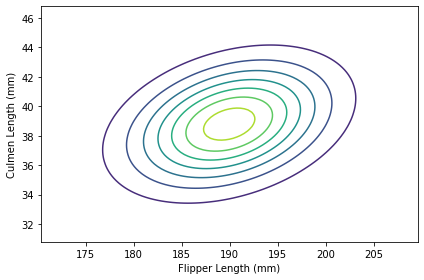

In [58]:
plot_contour(joint)
decorate(ylabel=var1,
         xlabel=var2)

The contours of a multivariate normal distribution are still ellipses, but now that we have taken into account the correlation between the features, the ellipses are no longer aligned with the axes.

The following function encapsulate the steps we just did.

In [59]:
def make_joint(norm1, norm2, multinorm):
    """Make a joint distribution.
    
    norm1: `norm` object representing the distribution of the first feature
    norm2: `norm` object representing the distribution of the second feature
    multinorm: `multivariate_normal` object representing the joint distribution
    """
    pmf1 = make_pmf(norm1)
    pmf2 = make_pmf(norm2)
    X, Y = np.meshgrid(pmf1.qs, pmf2.qs)
    pos = np.dstack((X, Y))
    a = multinorm.pdf(pos)
    joint = pd.DataFrame(a, index=pmf1.qs, columns=pmf2.qs)
    return joint

The following figure shows a scatterplot of the data along with the contours of the multivariate normal distribution for each species.

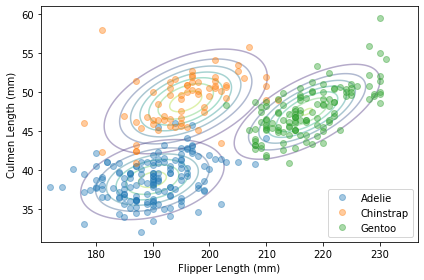

In [60]:
scatterplot(df, var1, var2)

for species in hypos:
    norm1 = culmen_map[species]
    norm2 = flipper_map[species]
    multinorm = multinorm_map[species]
    joint = make_joint(norm1, norm2, multinorm)
    plot_contour(joint, alpha=0.4)
    
savefig('fig10-03')

Because it takes the correlations into account, the multivariate normal distribution is a better model for the data.  And there is less overlap in the contours of the three distributions, which suggests that they should yield better classifications.

## A less naive classifier

In a previous section we used `update_penguin` to update a prior `Pmf` based on observed data and a collection of `norm` objects that model the distribution of observations under each hypothesis.
Here it is again:

In [61]:
def update_penguin(prior, data, norm_map):
    """Update hypothetical species.
    
    prior: Pmf
    data: 
    norm_map: map from hypothesis to distribution of data
    
    returns: posterior Pmf
    """
    hypos = prior.qs
    likelihood = [norm_map[hypo].pdf(data) for hypo in hypos]
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

I wrote this function with `norm` objects in mind, but it also works if the distributions in `norm_map` are `multivariate_normal` objects.  So we can call it like this:

In [62]:
data = 38, 190
update_penguin(prior, data, multinorm_map)

,probs
Adelie,0.996771
Chinstrap,0.003068
Gentoo,0.000161


A penguin with culmen length 38 and flipper length 190 is almost certainly an Adelie.

In [63]:
data = 48, 195
update_penguin(prior, data, multinorm_map)

,probs
Adelie,0.003101
Chinstrap,0.996877
Gentoo,0.000023


A penguin with culmen length 48 and flipper length 195 is almost certainly a Chinstrap.

In [64]:
data = 48, 215
update_penguin(prior, data, multinorm_map)

,probs
Adelie,0.000046
Chinstrap,0.005243
Gentoo,0.994710


And a penguin with culmen length 48 and flipper length 215 is almost certainly a Gentoo.

Let's see if this classifier does any better than the naive Bayesian classifier.
I'll apply it to each penguin in the dataset:

In [65]:
df['Classification'] = np.nan

for i, row in df.iterrows():
    data = row[varnames]
    posterior = update_penguin(prior, data, multinorm_map)
    df.loc[i, 'Classification'] = posterior.idxmax()

And compute the accuracy:

In [66]:
accuracy(df)

0.9532163742690059

It turns out to be only a little better: the accuracy is 95.3%, compared to 94.7% for the naive Bayesian classifier.

In one way, that's disappointing.  After all that work, it would have been nice to see a bigger difference.

But in another way, it's good news.  In general, a naive Bayesian classifier is easier to implement and requires less computation.  If it works nearly as well as a more complex algorithm, it might be a good choice for practical purposes.

But speaking of practical purposes, you might have noticed that this example isn't very useful.  If we want to identify the species of a penguin, there are easier ways than measuring its flippers and beak.

However, there is are valid scientific uses for this type of classification.  One of them is the subject of the research paper we started with: [sexual dimorphism](https://en.wikipedia.org/wiki/Sexual_dimorphism), that is, differences in shape between male and female animals.

In some species, like angler fish, males and females look very different.  In other species, like mockingbirds, they are difficult to tell apart.
And dimorphism is worth studying because it provides insight into social behavior, sexual selection, and evolution. 

One way to quantify the degree of sexual dimorphism in a species is to use a classification algorithm like the one in this chapter.  If you can find a set of features that makes it possible to classify individuals by sex with high accuracy, that's evidence of high dimorphism.

As an exercise, you can use the dataset from this chapter to classify penguins by sex and see which of the three species is the most dimorphic.

## Exercises

**Exercise:**  In my example I used culmen length and flipper length because they seemed to provide the most power to distinguish the three species.  But maybe we can do better by using more features.

Make a naive Bayesian classifier that uses all four measurements in the dataset: culmen length and depth, flipper length, and body mass.
Is it more accurate than the model with two features?

In [67]:
depth_map = make_norm_map(df, 'Culmen Depth (mm)')

In [68]:
mass_map = make_norm_map(df, 'Body Mass (g)')

In [69]:
varnames4 = ['Culmen Length (mm)', 'Flipper Length (mm)', 'Culmen Depth (mm)', 'Body Mass (g)']
norm_maps4 = [culmen_map, flipper_map, depth_map, mass_map]

In [70]:
df['Classification'] = np.nan

for i, row in df.iterrows():
    data_seq = row[varnames4]
    posterior = update_naive(prior, data_seq, norm_maps4)
    df.loc[i, 'Classification'] = posterior.max_prob()

In [71]:
accuracy(df)

0.9678362573099415

**Exercise:**  One of the reasons the penguin dataset was collected was to quantify sexual dimorphism in different penguin species, that is, physical differences between male and female penguins.  One way to quantify dimorphism is to use measurements to classify penguins by sex.  If a species is more dimorphic, we expect to be able to classify them more accurately.

As an exercise, pick a species and use a Bayesian classifier (naive or not) to classify the penguins by sex.  Which features are most useful?  What accuracy can you achieve?

Note: One Gentoo penguin has an invalid value for `Sex`.  I used the following code to select one species and filter out invalid data.

In [72]:
gentoo = df['Species2']=='Gentoo'
subset = df[gentoo].copy()

In [73]:
subset['Sex'].value_counts()

MALE      61
FEMALE    58
.          1
Name: Sex, dtype: int64

In [74]:
valid = df['Sex'] != '.'
valid.sum()

343

In [75]:
subset = df[valid & gentoo].copy()

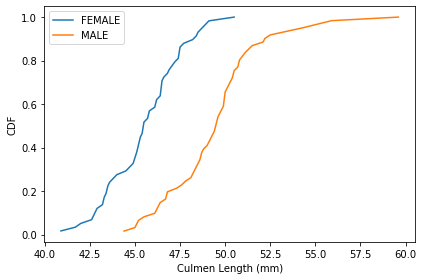

In [76]:
# Solution

plot_cdfs(subset, 'Culmen Length (mm)', by='Sex')

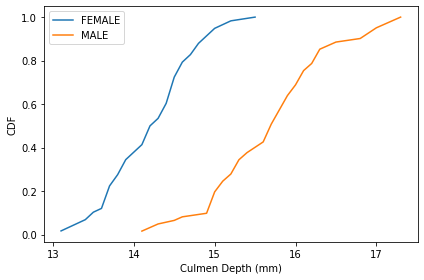

In [77]:
# Solution

plot_cdfs(subset, 'Culmen Depth (mm)', by='Sex')

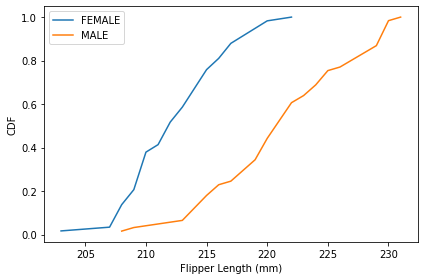

In [78]:
# Solution

plot_cdfs(subset, 'Flipper Length (mm)', by='Sex')

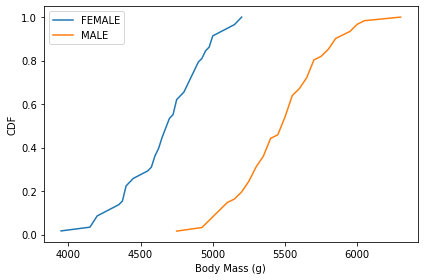

In [79]:
# Solution

plot_cdfs(subset, 'Body Mass (g)', by='Sex')

In [80]:
# Solution

culmen_map = make_norm_map(subset, 'Culmen Length (mm)', by='Sex')
flipper_map = make_norm_map(subset, 'Flipper Length (mm)', by='Sex')
depth_map = make_norm_map(subset, 'Culmen Depth (mm)', by='Sex')
mass_map = make_norm_map(subset, 'Body Mass (g)', by='Sex')

In [81]:
# Solution

norm_maps4 = [culmen_map, flipper_map, depth_map, mass_map]
varnames4 = ['Culmen Length (mm)', 'Flipper Length (mm)', 
             'Culmen Depth (mm)', 'Body Mass (g)']

In [82]:
# Solution

hypos = culmen_map.keys()
prior = Pmf(1/2, hypos)
prior

,probs
FEMALE,0.5
MALE,0.5


In [83]:
# Solution

subset['Classification'] = np.nan

for i, row in subset.iterrows():
    data_seq = row[varnames4]
    posterior = update_naive(prior, data_seq, norm_maps4)
    subset.loc[i, 'Classification'] = posterior.max_prob()

In [84]:
# Solution

def accuracy_sex(df):
    """Compute the accuracy of classification.
    
    Compares columns Classification and Sex
    
    df: DataFrame
    """
    valid = df['Classification'].notna()
    same = df['Sex'] == df['Classification']
    return same.sum() / valid.sum()

In [85]:
# Solution

accuracy_sex(subset)

0.9262295081967213

In [86]:
# Solution

def classify_by_sex(subset):
    """Run the whole classification process.
    
    subset: DataFrame
    """
    culmen_map = make_norm_map(subset, 'Culmen Length (mm)', by='Sex')
    flipper_map = make_norm_map(subset, 'Flipper Length (mm)', by='Sex')
    depth_map = make_norm_map(subset, 'Culmen Depth (mm)', by='Sex')
    mass_map = make_norm_map(subset, 'Body Mass (g)', by='Sex')

    norm_maps4 = [culmen_map, flipper_map, depth_map, mass_map]

    hypos = culmen_map.keys()
    prior = Pmf(1/2, hypos)

    subset['Classification'] = np.nan

    for i, row in subset.iterrows():
        data_seq = row[varnames4]
        posterior = update_naive(prior, data_seq, norm_maps4)
        subset.loc[i, 'Classification'] = posterior.max_prob()
        
    return accuracy_sex(subset)

In [87]:
# Solution

adelie = df['Species2']=='Adelie'
subset = df[adelie].copy()
classify_by_sex(subset)

0.8807947019867549

In [88]:
# Solution

chinstrap = df['Species2']=='Chinstrap'
subset = df[chinstrap].copy()
classify_by_sex(subset)

0.9264705882352942